This notebook takes borehole data from the East Kimberley that have depth to base of the cenozoic estimated, uses borehole data to build ml models to classify the stratigraphy (cenozoic or bedrock) and then predicts the values at boreholes without interpretations.

Neil Symington
neil.symington@ga.gov.au

In [1]:
%matplotlib inline

In [2]:
from sqlite3 import dbapi2 as sqlite
import pandas as pd
import fiona
from shapely.geometry import Polygon, shape
from shapely import wkt
import numpy as np
from hydrogeol_utils import spatial_functions, AEM_utils, plotting_utils, borehole_utils
from geophys_utils._netcdf_point_utils import NetCDFPointUtils
import matplotlib.pyplot as plt
import os
import math
import sqlalchemy as db
from sqlalchemy import create_engine, event
import netCDF4
import yaml
import warnings
warnings.filterwarnings("ignore",category =RuntimeWarning)
from hydrogeol_utils.db_utils import makeCon, closeCon

C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
def search(kword_dict, word):
    """
    A search function for finding if a keword
    exists as a list element within a dictionary entry
    
    @param kword_dict: dictionary with keywords
    @word: string
    returns
    the key for the entry if it exists or None if not
    """
    word = word.lower()
    for k in kword_dict:
        for v in kword_dict[k]:
            if word in v:
                return k
    return None

# Function for assigning stratigraphy above and below a point
# for a given downhole log/ layered model
def assign_stratigraphy_from_depth(df, depth, depth_columns, labels = ['cenozoic', 'mixed_signal', 'basement']):
    
    df['stratigraphy'] = ''
    
    if depth_columns == ['Depth']:
        
        for index, row in df.iterrows():
            if row['Depth'] < depth:
                df.at[index, 'stratigraphy'] = labels[0]
            elif row['Depth'] == depth:
                df.at[index, 'stratigraphy'] = labels[1]
            elif row['Depth'] > depth:
                df.at[index, 'stratigraphy'] = labels[2]
        return df
    
    elif depth_columns == ['Depth_from', 'Depth_to']:
        for index, row in df.iterrows():
            if row['Depth_to'] < depth:
                df.at[index, 'stratigraphy'] = labels[0]
            elif (row['Depth_from'] < depth) & (row['Depth_to'] > depth):
                df.at[index, 'stratigraphy'] = labels[1]
            elif row['Depth_from'] > depth:
                df.at[index, 'stratigraphy'] = labels[2]
        return df
    
def resample_categorical_intervals(df, parameter_columns,
                                   interval_columns, new_intervals):
    # If the parameter input is a string and not a list make it a list
    if isinstance(parameter_columns, ("".__class__, u"".__class__)):
        parameter_columns = [parameter_columns]
    
    # Create a dataframe to add to
    df_resampled = pd.DataFrame(columns = interval_columns, data = new_intervals)
    
    for p in parameter_columns:
        
        df_resampled[p] = ''
        
        # Iterate through the new intervals
        for i, interval in enumerate(new_intervals):
            
            new_depth_from = interval[0]
            new_depth_to = interval[1]

            mask = (df[interval_columns[0]] < new_depth_to) & (df[interval_columns[1]] > new_depth_from)
            
            v = df[mask][p].mode()
            
            if len(v) == 1:
                
                df_resampled.at[i, p] = v.values[0]
            
            elif len(v) > 1:

                df_resampled.at[i, p] = 'transition'
    
    return df_resampled

  

In [4]:
# Extract data from the database

path = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\Bores_working\compilation\spatialite"

DB_PATH = os.path.join(path, "East_Kimberley_borehole_data.sqlite")

SPATIALITE_PATH = r'C:\mod_spatialite-4.3.0a-win-amd64'

# Add spatialite dll to path
os.environ['PATH'] = SPATIALITE_PATH + ';' + os.environ['PATH']

engine = db.create_engine('sqlite:///' + DB_PATH, module=sqlite)

@event.listens_for(engine, 'connect')
def connect(dbapi_connection, connection_rec):
    dbapi_connection.enable_load_extension(True)
    dbapi_connection.execute('SELECT load_extension("mod_spatialite")')


connection = makeCon(DB_PATH)


Connected to \\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\Bores_working\compilation\spatialite\East_Kimberley_borehole_data.sqlite. Temporary working copy created.


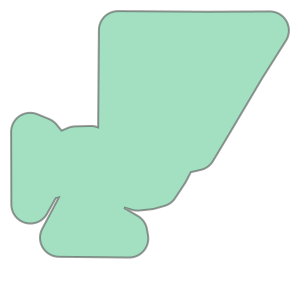

In [5]:
# AS we are only interested in the Keep Palaeovalley we will remove the bore that are outside of the
# Keep River polygon

# Open geometry for a shapefile. This will be used to filter the bores extracted from the database
c = fiona.open(r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\Neil\Keep_spatial\Keep_River_polygons.shp")
collection = [ shape(item['geometry']) for item in c ]
names = [item['properties']['Name'] for item in c]
polygons = [Polygon(pol.exterior.coords) for pol in collection] 

# Buffer by 5000 metres
OrdKeep = polygons[names.index('water_table_clip')].buffer(5000.)

# Now keep only bores that are within 
OrdKeep

In [6]:
# Now lets import the interpreted depths

# Bring in the interpreted depth to the base of the ceonozoic
infile = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\Bores_working\compilation\stratigraphy\EK_SonicStratigraphySummary.csv"

df_interp = pd.read_csv(infile)

df_header = borehole_utils.extract_sql_with_primary_key("borehole", ['*'],  connection, df_interp['borehole_id'].unique(),
                                                        verbose = True)

# Add borehole spatial data
df_interp = df_interp.merge(df_header[['borehole_id','Easting', 'Northing',
                                       'Ground_elevation_mAHD', 'geometry']],
                            on = 'borehole_id')

select t.* from borehole t where t.borehole_id in (635920,635728,635729,635730,635733,635734,635735,635737,635738,635739,635740,635741,635742,635743,635745,635746,635747,635748,635749);


In [7]:
df_interp = df_interp[[wkt.loads(x).within(OrdKeep) for x in df_interp['geometry']]]
df_header =df_header[[wkt.loads(x).within(OrdKeep) for x in df_header['geometry']]]

# Get the enos
enos = df_interp['borehole_id'].unique()

utm_zone = 52
54 points in UTM bounding box: [500049.774, 8292360.686, 542732.935, 8331311.342]


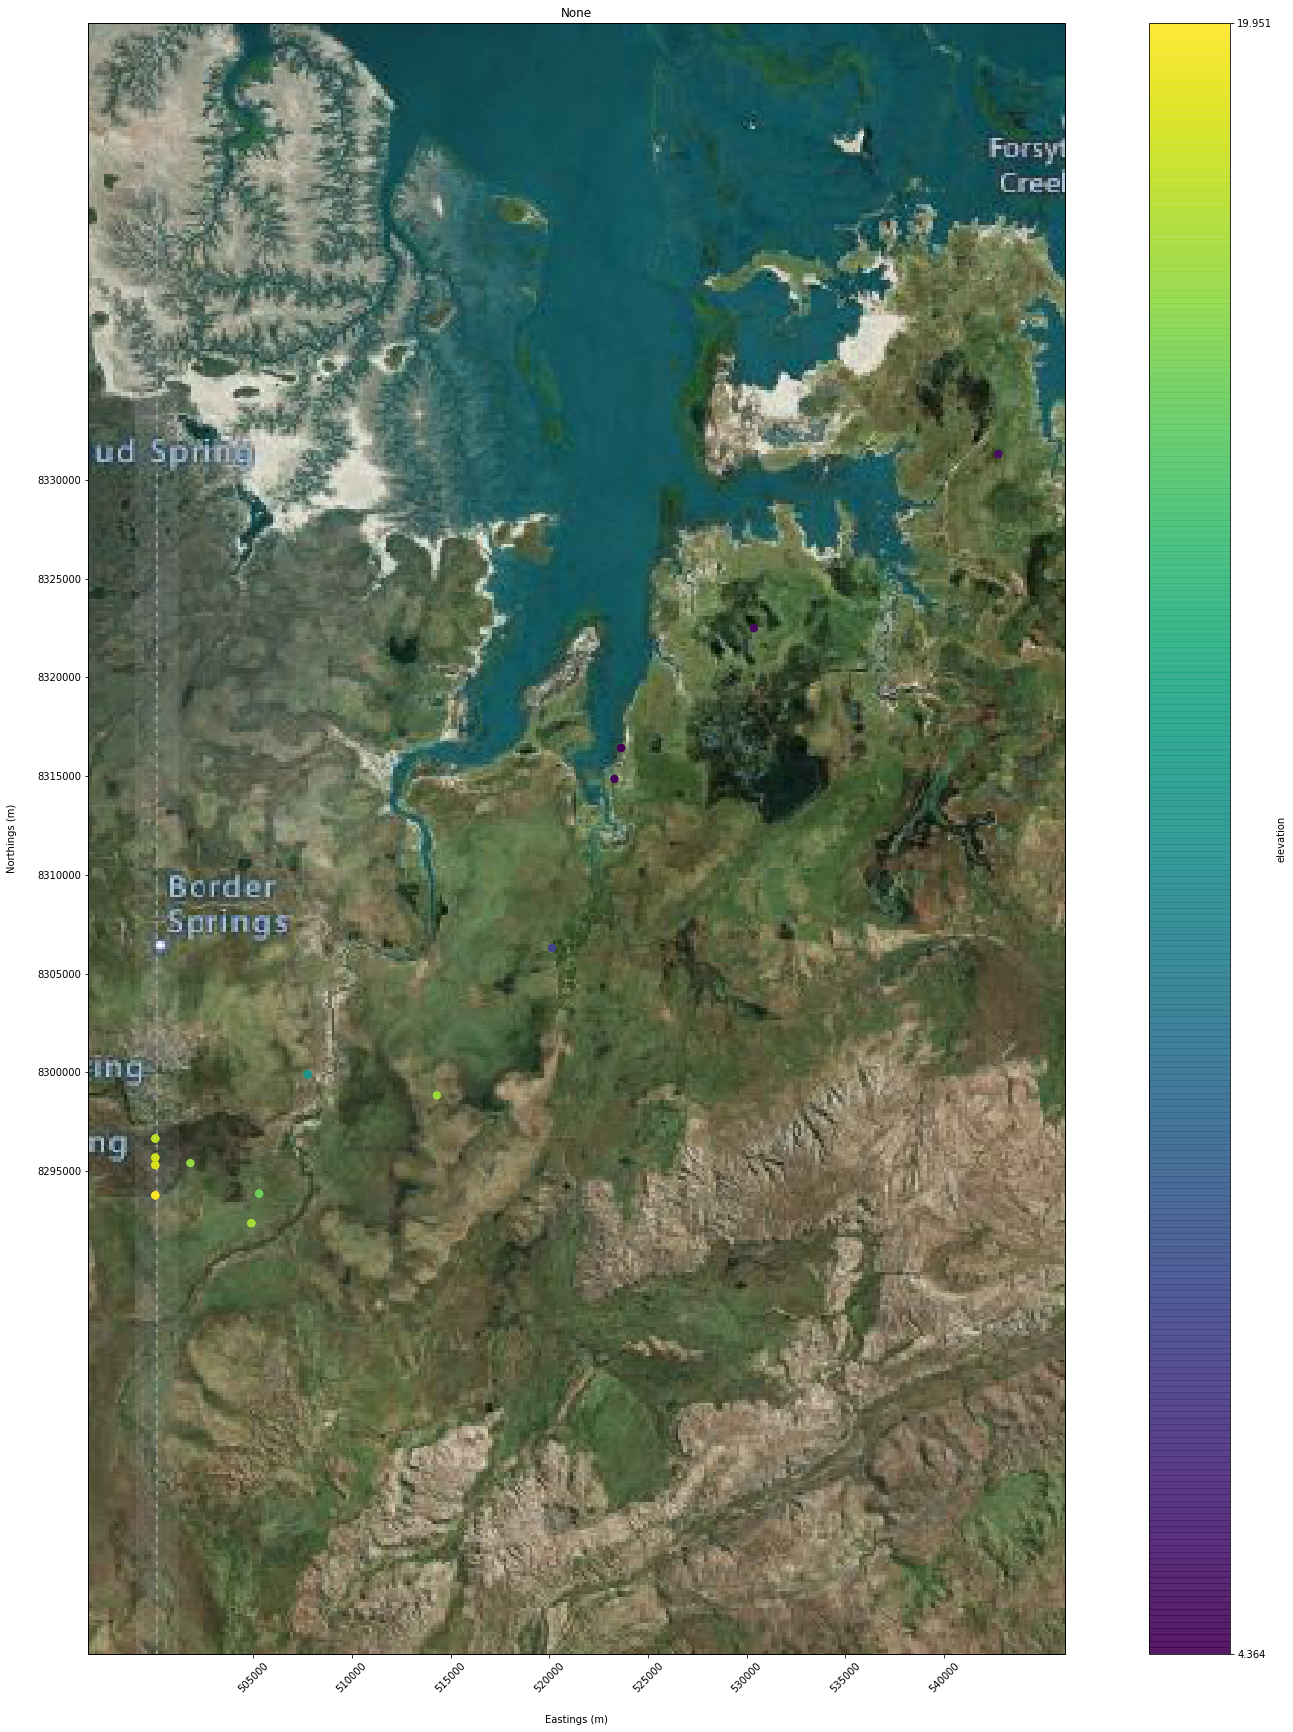

In [8]:
# Plot the bores on a basemap to get an idea of what datasets are available

utm_coords = df_interp[['Easting', 'Northing']].values

depth = df_interp['Ground_elevation_mAHD'].values

plotting_utils.plot_point_dataset(utm_coords, "EPSG:28352", depth,
                   colourbar_label = 'elevation', colour_scheme = 'viridis',
                    point_size=50)


In [9]:
# First import all the datasets based on our enos (primary key)


df_bNMR = borehole_utils.extract_sql_with_primary_key("boreholeNMR_data", ['Depth', 'Total_water_content',
                                                'Clay_water_content', 'Capillary_water_content',
                                               'Free_water_content', 'K_SDR', 'borehole_id'], connection, enos,
                                                verbose = True)

df_lithology = borehole_utils.extract_sql_with_primary_key("borehole_lithology", ['Depth_from', 'Depth_to',
                                                'Lithology_type',
                                                           'borehole_id'], connection, enos,
                                                          verbose = True)


# Classify the lithology using a yaml file keyword lookup table
yaml_file = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\Bores_working\compilation\classification\hydclass_classification.yml"

with open(yaml_file) as f:
    # use safe_load instead load
    hyd_class = yaml.safe_load(f)


# Assign all rows to a class of 7 which is the unkown class
df_lithology['hydraulic_class'] = 7

# iterate through lithology names
for index, row in df_lithology.iterrows():
    lithname = row.Lithology_type
    
    # Add the classification integer to the dataframe if it is found
    interval_class = search(hyd_class, lithname)
    
    if interval_class is not None:
        df_lithology.at[index, 'hydraulic_class'] = interval_class
    else:
        # Otherwise we can add it to the yaml file
        print(lithname)
    
    

df_indgam = borehole_utils.extract_sql_with_primary_key("induction_gamma_data", 
                                                        ['Depth', 'Apparent_conductivity','Gamma_calibrated',
                                                         'GR','borehole_id'], connection, enos,
                                                       verbose = True)



df_EC_pH = borehole_utils.extract_sql_with_primary_key("pore_fluid_EC_pH", 
                                                       ['Depth', 'EC', 'pH', 'borehole_id'],
                                                       connection, enos, verbose = True)

df_AEM = borehole_utils.extract_sql_with_primary_key("representative_AEM_bulk_conductivity", 
                                                       ['Depth_from', 'Depth_to', 'Bulk_conductivity', 'borehole_id'],
                                                       connection, enos, verbose = True)

df_magsus = borehole_utils.extract_sql_with_primary_key("magnetic_susceptibility", 
                                                       ['Depth', 'Magnetic_susceptibility', 'borehole_id'],
                                                       connection, enos, verbose = True)

df_hylog_SWIR = borehole_utils.extract_sql_with_primary_key("Hylogging_mineral_bin_rel_weight_SWIR", 
                                                       ['Depth', 'borehole_id', 'Kaolinite_PX_SWIR', 
                                                        'Kaolinite_WX_SWIR', 'Montmorillonite_SWIR',
                                                        'Muscovite_SWIR', 'MuscoviticIllite_SWIR'],
                                                       connection, enos, verbose = True)

df_hylog_TIR = borehole_utils.extract_sql_with_primary_key("Hylogging_mineral_bin_rel_weight_TIR", 
                                                       ['Depth', 'borehole_id', 'Quartz_TIR', 'Montmorillonite_TIR',
                                                        'Kaolinite_PX_TIR', 'Kaolinite_WX_TIR','Albite_TIR'],
                                                       connection, enos, verbose = True)

select t.Depth, t.Total_water_content, t.Clay_water_content, t.Capillary_water_content, t.Free_water_content, t.K_SDR, t.borehole_id from boreholeNMR_data t where t.borehole_id in (635728,635729,635730,635733,635734,635735,635737,635738,635739,635740,635741,635742,635743,635745,635746);
select t.Depth_from, t.Depth_to, t.Lithology_type, t.borehole_id from borehole_lithology t where t.borehole_id in (635728,635729,635730,635733,635734,635735,635737,635738,635739,635740,635741,635742,635743,635745,635746);
select t.Depth, t.Apparent_conductivity, t.Gamma_calibrated, t.GR, t.borehole_id from induction_gamma_data t where t.borehole_id in (635728,635729,635730,635733,635734,635735,635737,635738,635739,635740,635741,635742,635743,635745,635746);
select t.Depth, t.EC, t.pH, t.borehole_id from pore_fluid_EC_pH t where t.borehole_id in (635728,635729,635730,635733,635734,635735,635737,635738,635739,635740,635741,635742,635743,635745,635746);
select t.Depth_from, t.Depth_to, t.Bulk_conductivity,

In [10]:
# Now we want all the datasets to be on the same depth intervals for the sake of creating a matrix
# from which we can investigate the relationship between multiple variables and stratigraphy

# Lets try 1 m intervals

layer_thickness = 1.

# The data will be appended to a dataframe called interpolated

df_interpolated = pd.DataFrame(columns = ['borehole_id', 'Depth_from', 'Depth_to',
                                         'Bulk_conductivity', 'Cond_gradient', 'Gam_gradient', "EC", 'pH',
                                          'Total_water_content',
                                         'Clay_water_content', 'Capillary_water_content', 'Free_water_content',
                                          'magnetic_susceptibility', 'Kaolinite_PX_SWIR', 'Kaolinite_WX_SWIR',
                                          'Montmorillonite_SWIR',  'Muscovite_SWIR', 'MuscoviticIllite_SWIR',
                                          'Quartz_TIR', 'Montmorillonite_TIR', 'Kaolinite_PX_TIR', 'Kaolinite_WX_TIR',
                                          'Albite_TIR', 'stratigraphy'])

# Iterate through the bores

for index, row in df_header.iterrows():
    
    
    # First we want to find the max depth for the boreholes
    eno = row.borehole_id
    
    # Get the stratigraphy for the borehole
    df_strat_subset = borehole_utils.extract_by_primary_key(df_interp,
                                                           eno)
    
    
    # Round the interval values for ease of interpolation
    df_strat_subset.at[df_strat_subset.index,'Depth_from'] = df_strat_subset['Depth_from'].round()
    df_strat_subset.at[df_strat_subset.index,'Depth_to'] = df_strat_subset['Depth_to'].round()
    
    # Create
    
    
    min_depth = float(math.floor(df_interp[df_interp['borehole_id'] == eno]['Depth_from'].min()))

    max_depth = float(math.ceil(df_interp[df_interp['borehole_id'] == eno]['Depth_to'].max()))
    
    # Create depth from and depth to array
    
    depth_from = np.arange(min_depth, max_depth, layer_thickness)
    
    depth_to = np.arange(min_depth + layer_thickness, max_depth + layer_thickness, layer_thickness)
    

    new_intervals = pd.DataFrame(columns = ['Depth_from', 'Depth_to'],
                                 data = np.hstack((depth_from.reshape([-1,1]), depth_to.reshape([-1,1]))))

    # Now we want to create a new dataframe with the new intervals and the resampled stratigraphy
    
    df_resampled = resample_categorical_intervals(df_strat_subset, ['stratigraphy'],
                                   ['Depth_from', 'Depth_to'], new_intervals.values)
    
    # Lets do the same with lithology
    
    if row['Lithology_available']:
        
        df_lith_subset = borehole_utils.extract_by_primary_key(df_lithology,
                                                           eno)
        # Define variable column name(s)
        cols = ['hydraulic_class']
        
        df_lith_subset.at[df_lith_subset.index, 'hydraulic_class'] = [str(x) for x in df_lith_subset['hydraulic_class']]
        
        
        # Round the columns to the nearest metre
        df_lith_subset.at[df_lith_subset.index,'Depth_from'] = df_lith_subset['Depth_from'].round()
        
        df_lith_subset.at[df_lith_subset.index,'Depth_to'] = df_lith_subset['Depth_to'].round()
        
        df_lith_resampled = resample_categorical_intervals(df_lith_subset, ['hydraulic_class'],
                                   ['Depth_from', 'Depth_to'], new_intervals.values)
        
        # Interpolate
        df_resampled[cols] = df_lith_resampled[cols]
        
    
    # Now we interpolate the layered AEM model on these intervals if the data exists
    
    if row.AEM_conductivity_available:
        
        df_cond_subset = borehole_utils.extract_by_primary_key(df_AEM,
                                                           eno)
        # Define variable column name(s)
        cols = ['Bulk_conductivity']
        # Interpolate
        df_newcond = spatial_functions.interpolate_layered_model(df_cond_subset,
                                                                 cols,
                                                                 ["Depth_from",
                                                                  "Depth_to"],
                                                                  new_intervals)
        # Add as a new column to the lith subset frame
        df_resampled[cols] = df_newcond[cols]
        
    
    # Subset the induction and gamma data
    
    # The exact way of dealing with the variable data coverage will be subset specific
    # Some bore will have on 
    if (row.Induction_acquired) or (row.Gamma_acquired):
        
        df_indgam_subset = borehole_utils.extract_by_primary_key(df_indgam,
                                                           eno)
        
        # Since there are questions about the reliability of the induction tool and we have 
        # gamma in counts per second as well as other units we wil trial using teh gradients of
        # apparent conductivity and gamma

        df_indgam_subset['Cond_gradient'] = np.gradient(df_indgam_subset['Apparent_conductivity'].rolling(center=False,window=10,
                                                                                            min_periods = 5).mean())

        df_indgam_subset['Gam_gradient'] = np.gradient(df_indgam_subset['GR'].rolling(center=False,window=10,
                                                                       min_periods = 5).mean())
        
        # Define variable column name(s)
        cols = ['Cond_gradient','Gam_gradient']
        # Interpolate this time using the point depth to interval fucntion
        df_newindgam = spatial_functions.interpolate_depths_to_intervals(df_indgam_subset,
                                                                         cols,
                                                                        new_intervals)
        
        # Add as a new column to the lith subset frame
        df_resampled[cols] = df_newindgam[cols]
    
    # EC and pH
    if row.EC_pH_acquired:
        
        df_ECpH_subset = borehole_utils.extract_by_primary_key(df_EC_pH,
                                                           eno)
        
        # Define variable column name(s)
        cols = ['EC', "pH"]
        
        # Interpolate this time using the point depth to interval fucntion
        df_newECpH = spatial_functions.interpolate_depths_to_intervals(df_ECpH_subset,
                                                                         cols,
                                                                         new_intervals)
        # Add as a new column to the lith subset frame
        df_resampled[cols] = df_newECpH[cols]
    
    # Borehole NMR
    if row.Javelin_acquired:
        
        df_bNMR_subset = borehole_utils.extract_by_primary_key(df_bNMR,
                                                           eno)
        # Define variable column name(s)
        cols = ['Total_water_content', 'Clay_water_content',
                'Capillary_water_content', 'Free_water_content']
        # Interpolate
        df_newbNMR = spatial_functions.interpolate_depths_to_intervals(df_bNMR_subset,
                                                                         cols,
                                                                         new_intervals)
        # Add as a new column to the lith subset frame
        df_resampled[cols] = df_newbNMR[cols]
    
    # Magsus
    if row.MagSus_available:
        
        df_magsus_subset = borehole_utils.extract_by_primary_key(df_magsus,
                                                           eno)
        # Define variable column name(s)
        cols = ['Magnetic_susceptibility']
        
        # Interpolate
        df_newmagsus = spatial_functions.interpolate_depths_to_intervals(df_magsus_subset,
                                                                         cols, new_intervals)
        # Add as a new column to the lith subset frame
        df_resampled[cols] = df_newmagsus[cols]
        
    # Hylogger data
    if row.Hylogger_acquired_on_core:
        
        df_hylog_SWIR_subset = borehole_utils.extract_by_primary_key(df_hylog_SWIR,
                                                           eno)
        # Define variable column name(s)
        cols = ['Kaolinite_PX_SWIR', 'Kaolinite_WX_SWIR', 'Montmorillonite_SWIR',
                'Muscovite_SWIR', 'MuscoviticIllite_SWIR']
        # Interpolate
        df_newhylog = spatial_functions.interpolate_depths_to_intervals(df_hylog_SWIR_subset,
                                                                         cols, new_intervals)
        # Add as a new column to the lith subset frame
        df_resampled[cols] = df_newhylog[cols]
        
        df_hylog_TIR_subset = borehole_utils.extract_by_primary_key(df_hylog_TIR,
                                                           eno)
        # Define variable column name(s)
        cols = ['Quartz_TIR', 'Montmorillonite_TIR', 'Kaolinite_PX_TIR', 'Kaolinite_WX_TIR','Albite_TIR']
        # Interpolate
        df_newhylog = spatial_functions.interpolate_depths_to_intervals(df_hylog_TIR_subset,
                                                                         cols, new_intervals)
        # Add as a new column to the lith subset frame
        df_resampled[cols] = df_newhylog[cols]
    
    # Add the borehole id
    df_resampled['borehole_id'] = eno
    
    # Append to dataframe
    df_interpolated = df_interpolated.append(df_resampled)
        
        
# Remove any columns without any entries

df_interpolated.dropna(axis = 1, how = 'all', inplace = True)

df_interpolated.reset_index(inplace = True, drop = True)

df_interpolated = df_interpolated[df_interpolated['stratigraphy'] != ''] 

C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

In [11]:
# Check for null values

print(df_interpolated.isnull().sum(axis = 0))

Albite_TIR                  99
Bulk_conductivity            0
Capillary_water_content    121
Clay_water_content         121
Cond_gradient               73
Depth_from                   0
Depth_to                     0
EC                         434
Free_water_content         121
Gam_gradient                72
Kaolinite_PX_SWIR           99
Kaolinite_PX_TIR            99
Kaolinite_WX_SWIR           99
Kaolinite_WX_TIR            99
Magnetic_susceptibility    149
Montmorillonite_SWIR        99
Montmorillonite_TIR         99
Muscovite_SWIR              99
MuscoviticIllite_SWIR       99
Quartz_TIR                  99
Total_water_content        121
borehole_id                  0
hydraulic_class              0
pH                         435
stratigraphy                 0
dtype: int64


In [12]:
# NOw we want our stratigraphy to be in a numerical form

strat_dict = {'Cenozoic sediments':0,
              'Permo-Carboniferous':1,
              'Milligans Formation':2}

df_interpolated['strat_ind'] = [strat_dict[s] for s in df_interpolated['stratigraphy']]

In [13]:
# Now we prepare these data for some machine learning

from sklearn import preprocessing

features = ['Albite_TIR', 'Cond_gradient', 'Bulk_conductivity',
       'Capillary_water_content', 'Clay_water_content', 
            'EC', 'Free_water_content', 'Gam_gradient', 'Kaolinite_PX_SWIR',
       'Kaolinite_PX_TIR', 'Kaolinite_WX_SWIR', 'Kaolinite_WX_TIR',
       'Magnetic_susceptibility', 'Montmorillonite_SWIR',
       'Montmorillonite_TIR', 'Muscovite_SWIR', 'MuscoviticIllite_SWIR',
       'Quartz_TIR', 'Total_water_content', 'hydraulic_class',
       'pH']

labels = 'strat_ind'

n_strat = len(df_interpolated['strat_ind'].unique())

# Store well labels and depths
borehole = df_interpolated['borehole_id'].values
depth = df_interpolated['Depth_from'].values


# Store features and labels
X = df_interpolated[features].values 
y = df_interpolated[labels].values


# Fill 'PE' missing values with mean
imp = preprocessing.Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(X)
X = imp.transform(X)


In [14]:
from tpot import TPOTClassifier
from sklearn.model_selection import train_test_split

# Split
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.75,
                                                    test_size=0.25, shuffle=True)

# WE use tpot to pick the best pipeline

tpot = TPOTClassifier(verbosity=2, max_time_mins=2)

tpot.fit(X_train, y_train)


2.0008500000000002 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: GradientBoostingClassifier(GaussianNB(input_matrix), learning_rate=0.5, max_depth=6, max_features=0.05, min_samples_leaf=15, min_samples_split=2, n_estimators=100, subsample=0.25)


TPOTClassifier(config_dict=None, crossover_rate=0.1, cv=5,
        disable_update_check=False, early_stop=None, generations=1000000,
        max_eval_time_mins=5, max_time_mins=2, memory=None,
        mutation_rate=0.9, n_jobs=1, offspring_size=None,
        periodic_checkpoint_folder=None, population_size=100,
        random_state=None, scoring=None, subsample=1.0, use_dask=False,
        verbosity=2, warm_start=False)

In [15]:
# Test the classifier on the test set

print(tpot.score(X_test, y_test))
tpot.export(r"C:\temp\tpot_mnist_pipeline.py")

0.967032967032967


In [16]:
# The next step is to bring in the bores without stratigraphic picks and
# estimate the depth to class for each interval

st_key = ','.join(str(x) for x in df_interpolated.borehole_id.unique())

query = "select t.* from borehole t where not t.borehole_id in ({})".format(st_key)

df_bores = pd.read_sql(query, connection)

df_bores =df_bores[[wkt.loads(x).within(OrdKeep) for x in df_bores['geometry']]]

enos = df_bores.borehole_id.unique()

In [17]:
# First import all the datasets based on our enos (primary key)


df_bNMR = borehole_utils.extract_sql_with_primary_key("boreholeNMR_data", ['Depth', 'Total_water_content',
                                                'Clay_water_content', 'Capillary_water_content',
                                               'Free_water_content', 'K_SDR', 'borehole_id'], connection, enos,
                                                verbose = True)

   

df_indgam = borehole_utils.extract_sql_with_primary_key("induction_gamma_data", 
                                                        ['Depth', 'Apparent_conductivity','Gamma_calibrated',
                                                         'GR','borehole_id'], connection, enos,
                                                       verbose = True)



df_AEM = borehole_utils.extract_sql_with_primary_key("representative_AEM_bulk_conductivity", 
                                                       ['Depth_from', 'Depth_to', 'Bulk_conductivity', 'borehole_id'],
                                                       connection, enos, verbose = True)


df_hylog_SWIR = borehole_utils.extract_sql_with_primary_key("Hylogging_mineral_bin_rel_weight_SWIR", 
                                                       ['Depth', 'borehole_id', 'Kaolinite_PX_SWIR', 
                                                        'Kaolinite_WX_SWIR', 'Montmorillonite_SWIR',
                                                        'Muscovite_SWIR', 'MuscoviticIllite_SWIR'],
                                                       connection, enos, verbose = True)

df_hylog_TIR = borehole_utils.extract_sql_with_primary_key("Hylogging_mineral_bin_rel_weight_TIR", 
                                                       ['Depth', 'borehole_id', 'Quartz_TIR', 'Montmorillonite_TIR',
                                                        'Kaolinite_PX_TIR', 'Kaolinite_WX_TIR','Albite_TIR'],
                                                       connection, enos, verbose = True)


select t.Depth, t.Total_water_content, t.Clay_water_content, t.Capillary_water_content, t.Free_water_content, t.K_SDR, t.borehole_id from boreholeNMR_data t where t.borehole_id in (626981,626984,626986,626987,626988,626989,626990,626991,626992,635732,635736,635744,635921,635957,635958,635959,635960,636181,636182,636183,636184,636185,636189,636190,636191,636193,636194,636195,636196,636197,636198,636200,636201,636204,636205);
select t.Depth, t.Apparent_conductivity, t.Gamma_calibrated, t.GR, t.borehole_id from induction_gamma_data t where t.borehole_id in (626981,626984,626986,626987,626988,626989,626990,626991,626992,635732,635736,635744,635921,635957,635958,635959,635960,636181,636182,636183,636184,636185,636189,636190,636191,636193,636194,636195,636196,636197,636198,636200,636201,636204,636205);
select t.Depth_from, t.Depth_to, t.Bulk_conductivity, t.borehole_id from representative_AEM_bulk_conductivity t where t.borehole_id in (626981,626984,626986,626987,626988,626989,626990,626991,

In [18]:
# Now we want all the datasets to be on the same depth intervals for the sake of creating a matrix
# from which we can investigate the relationship between multiple variables and stratigraphy

# Lets try 1 m intervals

layer_thickness = 1.

# The data will be appended to a dataframe called interpolated

df_mud_rot = pd.DataFrame(columns = ['borehole_id', 'Depth_from', 'Depth_to',
                                         'Bulk_conductivity', 'Cond_gradient', 'Gam_gradient',
                                         'Total_water_content',
                                         'Clay_water_content', 'Capillary_water_content', 'Free_water_content',
                                          'Kaolinite_PX_SWIR', 'Kaolinite_WX_SWIR',
                                          'Montmorillonite_SWIR',  'Muscovite_SWIR', 'MuscoviticIllite_SWIR',
                                          'Quartz_TIR', 'Montmorillonite_TIR', 'Kaolinite_PX_TIR', 'Kaolinite_WX_TIR',
                                          'Albite_TIR'])

# Iterate through the bores

for index, row in df_bores.iterrows():
    
    
    # First we want to find the max depth for the boreholes
    eno = row.borehole_id
    
    # As we always have gamma we will use this to define our depth intervals
    
    df_indgam_subset = borehole_utils.extract_by_primary_key(df_indgam,
                                                           eno)    
    
    # Create
    
    
    min_depth = float(math.floor(df_indgam_subset['Depth'].min()))

    max_depth = float(math.ceil(df_indgam_subset['Depth'].max()))
    
    # Create depth from and depth to array
    
    depth_from = np.arange(min_depth, max_depth, layer_thickness)
    
    depth_to = np.arange(min_depth + layer_thickness, max_depth + layer_thickness, layer_thickness)
    

    new_intervals = pd.DataFrame(columns = ['Depth_from', 'Depth_to'],
                                 data = np.hstack((depth_from.reshape([-1,1]), depth_to.reshape([-1,1]))))

    # Now we want to create a new dataframe with the new intervals and the resampled stratigraphy
    
    df_resampled = new_intervals.copy()
    
        
    # Now we interpolate the layered AEM model on these intervals if the data exists
    
    if row.AEM_conductivity_available:
        
        df_cond_subset = borehole_utils.extract_by_primary_key(df_AEM,
                                                           eno)
        # Define variable column name(s)
        cols = ['Bulk_conductivity']
        # Interpolate
        df_newcond = spatial_functions.interpolate_layered_model(df_cond_subset,
                                                                 cols,
                                                                 ["Depth_from",
                                                                  "Depth_to"],
                                                                  new_intervals)
        # Add as a new column to the lith subset frame
        df_resampled[cols] = df_newcond[cols]
        
    
    # Subset the induction and gamma data
    
    # The exact way of dealing with the variable data coverage will be subset specific
    # Some bore will have on 
    if (row.Induction_acquired) or (row.Gamma_acquired):
        
        df_indgam_subset = borehole_utils.extract_by_primary_key(df_indgam,
                                                           eno)
        
        # Since there are questions about the reliability of the induction tool and we have 
        # gamma in counts per second as well as other units we wil trial using teh gradients of
        # apparent conductivity and gamma

        df_indgam_subset['Cond_gradient'] = np.gradient(df_indgam_subset['Apparent_conductivity'].rolling(center=False,
                                                                                                          window=10,
                                                                                   min_periods = 5).mean())

        df_indgam_subset['Gr_gradient'] = np.gradient(df_indgam_subset['GR'].rolling(center=False,window=10,
                                                               min_periods = 5).mean())

        df_indgam_subset['Gamcal_gradient'] = np.gradient(df_indgam_subset['Gamma_calibrated'].rolling(center=False,window=10,
                                                               min_periods = 5).mean())

        # Now we want to add the gamma gradient datasets together
        df_indgam_subset['Gam_gradient'] = df_indgam_subset[['Gr_gradient','Gamcal_gradient']].sum(axis = 1, min_count = 1)
        
        # Define variable column name(s)
        cols = ['Cond_gradient', 'Gam_gradient']
        # Interpolate this time using the point depth to interval fucntion
        df_newindgam = spatial_functions.interpolate_depths_to_intervals(df_indgam_subset,
                                                                         cols,
                                                                        new_intervals)
        
        # Add as a new column to the lith subset frame
        df_resampled[cols] = df_newindgam[cols]
    
    
    # Borehole NMR
    if row.Javelin_acquired:
        
        df_bNMR_subset = borehole_utils.extract_by_primary_key(df_bNMR,
                                                           eno)
        # Define variable column name(s)
        cols = ['Total_water_content', 'Clay_water_content',
                'Capillary_water_content', 'Free_water_content']
        # Interpolate
        df_newbNMR = spatial_functions.interpolate_depths_to_intervals(df_bNMR_subset,
                                                                         cols,
                                                                         new_intervals)
        # Add as a new column to the lith subset frame
        df_resampled[cols] = df_newbNMR[cols]
    
        
    # Hylogger data
    if (row.Hylogger_acquired_on_chips) or (row.Hylogger_acquired_on_core):
        
        
        
        df_hylog_SWIR_subset = borehole_utils.extract_by_primary_key(df_hylog_SWIR,
                                                           eno)
        # Define variable column name(s)
        cols = ['Kaolinite_PX_SWIR', 'Kaolinite_WX_SWIR', 'Montmorillonite_SWIR',
                'Muscovite_SWIR', 'MuscoviticIllite_SWIR']
        # Interpolate
        df_newhylog = spatial_functions.interpolate_depths_to_intervals(df_hylog_SWIR_subset,
                                                                         cols, new_intervals)
        # Add as a new column to the lith subset frame
        df_resampled[cols] = df_newhylog[cols]
        
        df_hylog_TIR_subset = borehole_utils.extract_by_primary_key(df_hylog_TIR,
                                                           eno)
        # Define variable column name(s)
        cols = ['Quartz_TIR', 'Montmorillonite_TIR', 'Kaolinite_PX_TIR', 'Kaolinite_WX_TIR','Albite_TIR']
        # Interpolate
        df_newhylog = spatial_functions.interpolate_depths_to_intervals(df_hylog_TIR_subset,
                                                                         cols, new_intervals)
        # Add as a new column to the lith subset frame
        df_resampled[cols] = df_newhylog[cols]
    
    
    # Add the borehole id
    df_resampled['borehole_id'] = eno
    
    # Append to dataframe
    df_mud_rot = df_mud_rot.append(df_resampled)
        
        
# Remove any columns without any entries

df_mud_rot.dropna(axis = 1, how = 'all', inplace = True)

df_mud_rot.reset_index(inplace = True, drop = True)


C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [19]:
# Now we iterate through the bores and make predictions


for index, row in df_bores.iterrows():
    eno = row.borehole_id
    mask = df_mud_rot['borehole_id'] == eno
    
    df_mud_rot_subset = df_mud_rot[mask]
    
    break
    

In [23]:
eno#df_mud_rot_subset

636205